# Seq2Seq
Eng -> Fra

# 1. 문자수준

## 1.1 데이터 전처리

In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import os

In [2]:
file_path = './data/seq2seq/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수: ', len(lines))
lines.sample(5)

전체 샘플의 수:  217975


,eng,fra,cc
214119,You must've been surprised to meet your teache...,Tu as dû être surprise de rencontrer ton profe...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
66282,Tom doesn't drink milk.,Tom ne boit pas de lait.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
128238,He did not regret his decision.,Il ne regretta pas sa décision.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
11869,It's all yours.,C'est tout à toi.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
84659,You didn't understand me.,Vous ne m'avez pas comprise.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...


cc column 불필요, 훈련 데이터는 5만개의 샘플로 줄이기

In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 사용
lines.sample(5)

,eng,fra
6343,Tom is small.,Tom est petit.
26309,I really miss Tom.,Tom me manque vraiment.
44309,You won't need that.,Tu n'en auras pas besoin.
7876,I surrendered.,Je me suis rendue.
45617,Have you seen my son?,As-tu vu mon fils ?


seq2seq 동작을 위하여 디코더의 입력과 예측에 $\texttt{<sos>}$, $\texttt{<eos>}$ 넣어주기

In [4]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x: '\t ' + x + ' \n')
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)

전체 샘플의 수 :  50000


,eng,fra
34762,That would be hard.,\t Ce serait dur. \n
48263,I've swept the floor.,\t J'ai balayé le sol. \n
11282,I saw her home.,\t Je l'ai vue à son domicile. \n
26171,I made it on time.,\t J'y suis arrivé à temps. \n
48648,Let me rest a little.,\t Laissez-moi me reposer un peu. \n


단어장을 만들고 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정. 이때 영어, 프랑스어 각각 다로 만들어준다.

In [5]:
eng_tokenizer = Tokenizer(char_level=True) #문자 단위로 토크나이징
eng_tokenizer.fit_on_texts(lines.eng) # 50000개의 행을 가진 fra의 각 행에 토믄화
input_text = eng_tokenizer.texts_to_sequences(lines.eng) # 단어를 숫자값 인덱스로 변환하여 저장

fra_tokenizer = Tokenizer(char_level=True) #문자 단위로 토크나이징
fra_tokenizer.fit_on_texts(lines.fra) # 50000개의 행을 가진 fra의 각 행에 토믄화
target_text = fra_tokenizer.texts_to_sequences(lines.fra) # 단어를 숫자값 인덱스로 변환하여 저장

input_text[:3], target_text[:3]

([[19, 4, 7], [19, 4, 7], [19, 4, 7]],
 [[10, 1, 19, 5, 1, 31, 1, 11],
  [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
  [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]])

단어장의 크기를 변수로 저장, 0번 토큰을 고려하여 +1을 하고 저장.

In [6]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print(f"영어 단어장 크기: {eng_vocab_size}, 프랑스 단어장 크기: {fra_vocab_size}")

영어 단어장 크기: 52, 프랑스 단어장 크기: 73


영어 데이터와 프랑스어 데이터의 최대 길이 각각 구해보기(패딩하기 위해서)

In [7]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print(f"영어 seq의 최대 길이: {max_eng_seq_len}, 프랑스 seq의 최대 길이: {max_fra_seq_len}")

영어 seq의 최대 길이: 21, 프랑스 seq의 최대 길이: 69


In [8]:
# 전체 통계
print('전체 샘플의 수 : ', len(lines))
print(f"영어 단어장 크기: {eng_vocab_size}, 프랑스 단어장 크기: {fra_vocab_size}")
print(f"영어 seq의 최대 길이: {max_eng_seq_len}, 프랑스 seq의 최대 길이: {max_fra_seq_len}")

전체 샘플의 수 :  50000
영어 단어장 크기: 52, 프랑스 단어장 크기: 73
영어 seq의 최대 길이: 21, 프랑스 seq의 최대 길이: 69


인코더의 입력으로 사용되는 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비해야 한다.  
1. 디코더의 출력과 비교해야 할 정답 데이터 - sos 토큰이 필요 없다
2. Teacher forcing을 위해 디코더의 입력으로 사용하기 위한 것 - eos 토큰이 필요 없다  
ex) 'I am a person' -> 'Je suis une personne'  
훈련과정)  '$\texttt{<sos>}$ Je suis une personne'를 입력, 'Je suis une personne $\texttt{<eos>}$'를 예측

In [9]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index[eos_token]] for line in target_text]
# 시작 토큰 제거
decoder_target = [[char for char in line if char != fra_tokenizer.word_index[sos_token]] for line in target_text]

In [10]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


decoder_input 숫자 10(sos 토큰)으로 시작 11(eos 토큰)삭제  
decoder_target 숫자 10(sos 토큰)으로 삭제 11(eos 토큰)로 끝남

In [11]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [12]:
print(encoder_input[0])

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [13]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69)


## 1.2 모델 학습


In [14]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

인코더 설계: LSTM의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해준다.

In [25]:
# 입력 텐서 생성
encoder_inputs = Input(shape=(None, eng_vocab_size))

# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units=256, return_state=True)

# 디코더로 전달할 hidden state, cell state를 리턴. encoder outputs는 여기서 불필요함.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

디코더 설계: 동일

In [26]:
# 입력 텐서 생성
decoder_inputs = Input(shape=(None, fra_vocab_size))

# hidden 256 인코더 lstm 셀 생성
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

디코더 출력층 설계: 매 time step마다 다중 클래스 분류 문제이므로 프랑스어 단어장으로부터 한가지 문자만 선택하도록

In [27]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

모델 정의

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 52)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 73)]   0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        316416      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

pydot을 설치, graphviz는 conda install로 설치

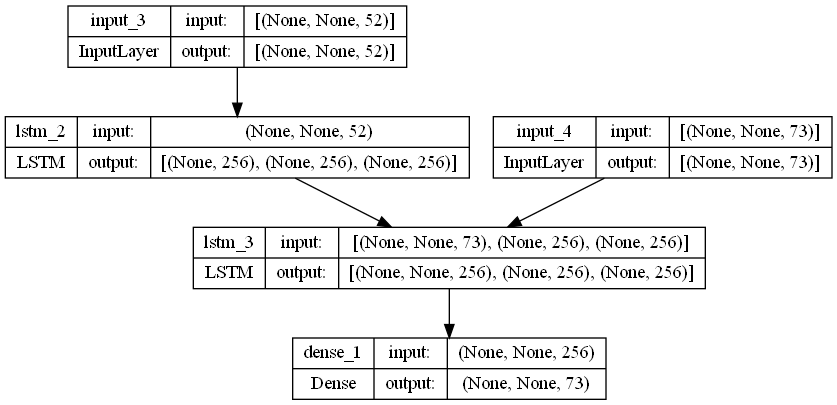

In [32]:
from keras.utils import plot_model
plot_model(model, expand_nested=True, show_shapes=True)

In [47]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\miniconda3\envs\datascience\lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 21)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 21), dtype=int32)', 'tf.Tensor(shape=(None, 69), dtype=int32)')
      • training=True
      • mask=None


## 1.3 모델 테스트